# Recommender Systems 2018/19

### Practice 9 - Collaborative Boosted FW


### Underlying idea... the way to capture the feature importance from the user point of view, is to... use its point of view (e.g., ratings, collaborative similarity)

## A few info about feature weightign techniques

* Information retrieval methods (TF-IDF, BM25..) do not optimize a predictive model
* Embedding methods (FISM, UFSM, Factorization Machines) optimize everything at the same time, model and weights, but are difficult to train and sensitive to noise
* Wrapper methods (LFW, CFW) apply a two step approach approximating an already built collaborative model, more robust and easier to tune


In [1]:
from urllib.request import urlretrieve
import zipfile

# skip the download
#urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", "data/Movielens_10M/movielens_10m.zip")
dataFile = zipfile.ZipFile("data/Movielens_10M/movielens_10m.zip")
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = "data/Movielens_10M")
URM_file = open(URM_path, 'r')


def rowSplit (rowString):
    
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = float(split[2])
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result


URM_file.seek(0)
URM_tuples = []

for line in URM_file:
   URM_tuples.append(rowSplit (line))

userList, itemList, ratingList, timestampList = zip(*URM_tuples)

userList = list(userList)
itemList = list(itemList)
ratingList = list(ratingList)
timestampList = list(timestampList)

import scipy.sparse as sps

URM_all = sps.coo_matrix((ratingList, (userList, itemList)))
URM_all = URM_all.tocsr()



In [2]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")
ICM_file = open(ICM_path, 'r')

def rowSplit (rowString):
    split = rowString.split("::")
    split[3] = split[3].replace("\n","")
    
    split[0] = int(split[0])
    split[1] = int(split[1])
    split[2] = str(split[2]) # tag is a string, not a float like the rating
    split[3] = int(split[3])
    
    result = tuple(split)
    
    return result

ICM_file.seek(0)
ICM_tuples = []

for line in ICM_file:
    ICM_tuples.append(rowSplit(line))
    
userList_icm, itemList_icm, tagList_icm, timestampList_icm = zip(*ICM_tuples)

userList_icm = list(userList_icm)
itemList_icm = list(itemList_icm)
tagList_icm = list(tagList_icm)
timestampList_icm = list(timestampList_icm)

userList_unique = list(set(userList_icm))
itemList_unique = list(set(itemList_icm))
tagList_unique = list(set(tagList_icm))

numUsers = len(userList_unique)
numItems = len(itemList_unique)
numTags = len(tagList_unique)


print ("Number of items\t {}, Number of users\t {}".format(numItems, numUsers))
print ("Number of tags\t {}, Number of item-tag tuples {}".format(numTags, len(tagList_icm)))

print("\nData example:")
print(userList_icm[0:10])
print(itemList_icm[0:10])
print(tagList_icm[0:10])


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(tagList_icm)

tagList_icm = le.transform(tagList_icm)

import numpy as np

ones = np.ones(len(tagList_icm))

ICM_all = sps.coo_matrix((ones, (itemList_icm, tagList_icm)), shape=(URM_all.shape[1], tagList_icm.max()+1))
ICM_all = ICM_all.tocsr()

Number of items	 7601, Number of users	 4009
Number of tags	 16529, Number of item-tag tuples 95580

Data example:
[15, 20, 20, 20, 20, 20, 20, 20, 20, 20]
[4973, 1747, 1747, 2424, 2424, 2424, 2947, 2947, 3033, 3033]
['excellent!', 'politics', 'satire', 'chick flick 212', 'hanks', 'ryan', 'action', 'bond', 'spoof', 'star wars']


In [4]:

from Notebooks_utils.data_splitter import train_test_holdout

URM_train, URM_test = train_test_holdout(URM_all, train_perc = 0.8)
URM_train, URM_validation = train_test_holdout(URM_train, train_perc = 0.9)

### To shorten the notebook let's use the parameters we computed the previous time (Warning: not very clean, the data split may be different)

In [5]:
best_params_ItemKNNCF = {'topK': 700, 'shrink': 200, 'similarity': 'cosine', 'normalize': True}
best_params_ItemKNNCBF = {'topK': 500, 'shrink': 1000, 'similarity': 'cosine', 'normalize': True}

### Step 1: Create the two models, collaborative and content based

In [6]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(**best_params_ItemKNNCF)

itemKNNCBF = ItemKNNCBFRecommender(ICM_all, URM_train)
itemKNNCBF.fit(**best_params_ItemKNNCBF)

Similarity column 65134 ( 100 % ), 2437.40 column/sec, elapsed time 0.45 min
Similarity column 65134 ( 100 % ), 2628.62 column/sec, elapsed time 0.41 min


### Question, how the two similarities differ?

In [8]:
W_sparse_CF = itemKNNCF.W_sparse
W_sparse_CBF = itemKNNCBF.W_sparse

## Let's plt the global similarity distribution 

In [14]:
W_sparse_CF_sorted = np.sort(W_sparse_CF.data.copy())
W_sparse_CBF_sorted = np.sort(W_sparse_CBF.data.copy())

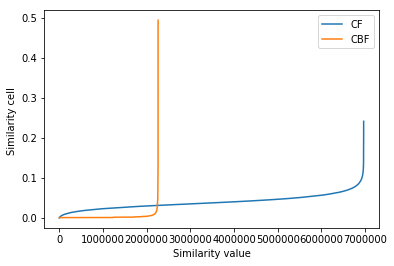

In [18]:
import numpy as np
import matplotlib.pyplot as pyplot


pyplot.plot(W_sparse_CF_sorted, label = 'CF')
pyplot.plot(W_sparse_CBF_sorted, label = 'CBF')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

## Let's now plot the delta for the common values

In [28]:
# Get common structure
W_sparse_CF_structure = W_sparse_CF.copy()
W_sparse_CF_structure.data = np.ones_like(W_sparse_CF_structure.data)

W_sparse_CBF_structure = W_sparse_CBF.copy()
W_sparse_CBF_structure.data = np.ones_like(W_sparse_CBF_structure.data)

W_sparse_common = W_sparse_CF_structure.multiply(W_sparse_CBF_structure)

# Get values of both in common structure of CF
W_sparse_delta = W_sparse_CBF.copy().multiply(W_sparse_common)
W_sparse_delta -= W_sparse_CF.copy().multiply(W_sparse_common)

In [29]:
W_sparse_delta_sorted = np.sort(W_sparse_delta.data.copy())

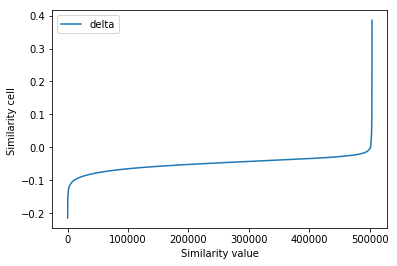

In [32]:
pyplot.plot(W_sparse_delta_sorted, label = 'delta')
pyplot.ylabel('Similarity cell ')
pyplot.xlabel('Similarity value')
pyplot.legend()
pyplot.show()

In [34]:
# How many values we have in common?

print("W_sparse_CF has {:.2E} values and {:.2f} % in common with CBF".format(W_sparse_CF.nnz, W_sparse_common.nnz/W_sparse_CF.nnz*100))
print("W_sparse_CBF has {:.2E} values and {:.2f} % in common with CF".format(W_sparse_CBF.nnz, W_sparse_common.nnz/W_sparse_CBF.nnz*100))

print("W_sparse_delta has {:.2E} values".format(W_sparse_delta.nnz))


W_sparse_CF has 6.97E+06 values and 7.24 % in common with CBF
W_sparse_CBF has 2.26E+06 values and 22.29 % in common with CF
W_sparse_delta has 5.04E+05 values


## What do we see?
## The great majority of similarities are not common... the models are modeling two very different phenomena

# Idea: 

## what if we were to weight features in such a way to approximate as well as possible the collaborative similarity?

### Basic model:  $S_{CBF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 


### We want  $S_{CBF} = S_{CF}$

### Hence we wish to find the weights such that  $S_{CF} = ICM \cdot diag(feature\_weights) \cdot ICM^{T}$ 

### Now, we can rearrange the equations considering that we need only weights for features the two items have in common... this becomes a regression problem in form Ax = b. In our case A are the common features, x the weights and b the collaborative similarity


### Since it is a regression problem, we can use an already available solver like linalg in scipy.sparse

### It takes as imput two data structures, one is sparse and the other is the target value

In [49]:
W_sparse_delta = W_sparse_delta.tocoo()


item_index_1 = W_sparse_delta.row[666]
item_index_2 = W_sparse_delta.col[666]

In [50]:
print("Item indices are {} and {}".format(item_index_1, item_index_2))

Item indices are 5 and 594


In [51]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

Collaborative similarity value is 0.055663395673036575
Content-based similarity value is 0.0018716327613219619


### Compute the common features

In [53]:
common_features = ICM_all[item_index_1,:].multiply(ICM_all[item_index_2,:])
common_features

<1x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [54]:
common_features.indices

array([8541], dtype=int32)

## These items have just a common feature, that is a common scenario

### Let's look for items having  a few features in common, say 5

In [56]:
min_common_features = 5

for inner_index in range(len(W_sparse_delta.row)):

    item_index_1 = W_sparse_delta.row[inner_index]
    item_index_2 = W_sparse_delta.col[inner_index]

    common_features = ICM_all[item_index_1,:].multiply(ICM_all[item_index_2,:])
    
    if common_features.nnz >= min_common_features:
        
        # Bad programming, don't do this at home
        break
        
        

print("Item indices are {} and {}".format(item_index_1, item_index_2))

print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))
    
common_features.indices

Item indices are 1 and 50
Collaborative similarity value is 0.11398738622665405
Content-based similarity value is 0.003887253813445568


array([ 6688,  9727, 10262, 11154, 15951, 16099], dtype=int32)

In [59]:
from scipy.sparse import linalg

loss_tolerance = 1e-6
iteration_limit = 50000
damp_coeff=0.0

W_sparse_CF_value = W_sparse_CF[item_index_1, item_index_2]

In [60]:
linalg_result = linalg.lsqr(common_features, W_sparse_CF_value, show = False, atol=loss_tolerance, btol=loss_tolerance,
                  iter_lim = iteration_limit, damp=damp_coeff)

In [62]:
feature_weights = linalg_result[0].copy()
feature_weights

array([0., 0., 0., ..., 0., 0., 0.])

In [63]:
feature_weights[common_features.indices]

array([0.01266527, 0.01266527, 0.01266527, 0.02533053, 0.01266527,
       0.01266527])

### Note that all weights will be zeros except for the features those items have in common, nothing can be learned if a feature is not common

### If a dataset has a very sparse ICM, this FW method will struggle

In [66]:
new_CBF_value = common_features.dot(feature_weights)
new_CBF_value

array([0.11398739])

In [67]:
print("Collaborative similarity value is {}".format(W_sparse_CF[item_index_1, item_index_2]))
print("Content-based similarity value is {}".format(W_sparse_CBF[item_index_1, item_index_2]))

print("Weighted Content-based similarity value is {}".format(new_CBF_value[0]))

Collaborative similarity value is 0.11398738622665405
Content-based similarity value is 0.003887253813445568
Weighted Content-based similarity value is 0.11398738622665405


### Note that we learned the CF similarity amost exactly...

### Warning: 5 common features and 1 similarity value, more parameters than data points, overfitting!

### if we want to apply this method to the whole dataset we have to compute the common features of all items having a common similarity value. Whe already know who they are, thanks to W_sparse_delta

In [72]:
from FW_Similarity.CFW_D_Similarity_Linalg import CFW_D_Similarity_Linalg

In [73]:
CFW_weithing = CFW_D_Similarity_Linalg(URM_train, ICM_all, W_sparse_CF)
CFW_weithing.fit()

CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 6897.72 column/sec, elapsed time 0.16 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.64E-03, nonzero cells 6967008
CFW_D_Similarity_Linalg: Content S density: 3.72E-04, nonzero cells 1576400
CFW_D_Similarity_Linalg: Content S structure has 392678 out of 1576400 ( 24.91%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.15E+04, average is: 5.48E-02, average over all collaborative data is 3.97E-02
Similarity column 65134 ( 100 % ), 7116.12 column/sec, elapsed time 0.15 min


In [84]:
from Base.Evaluation.Evaluator import SequentialEvaluator

evaluator_validation = SequentialEvaluator(URM_validation, cutoff_list=[5])
evaluator_test = SequentialEvaluator(URM_test, cutoff_list=[5])


In [81]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCF)
results_dict

SequentialEvaluator: Processed 26001 ( 37.21% ) in 30.80 seconds. Users per second: 844
SequentialEvaluator: Processed 52001 ( 74.42% ) in 61.17 seconds. Users per second: 850
SequentialEvaluator: Processed 69878 ( 100.00% ) in 80.82 seconds. Users per second: 865


{5: {'ROC_AUC': 0.469589856607227,
  'PRECISION': 0.40889621912480406,
  'RECALL': 0.059556315725128865,
  'RECALL_TEST_LEN': 0.40889621912480406,
  'MAP': 0.3072242694410256,
  'MRR': 0.600965492238863,
  'NDCG': 0.1129899049497923,
  'F1': 0.10396934806985085,
  'HIT_RATE': 2.0444488966484444,
  'ARHR': 0.9708320215231321,
  'NOVELTY': 0.0007028777345331591,
  'DIVERSITY_MEAN_INTER_LIST': 0.9240202330508582,
  'DIVERSITY_HERFINDAHL': 0.984801401943086,
  'COVERAGE_ITEM': 0.03437528786808733,
  'COVERAGE_USER': 0.9763860943438408,
  'DIVERSITY_GINI': 0.05660953478102653,
  'SHANNON_ENTROPY': 7.0490470489108334}}

In [82]:
results_dict, _ = evaluator_test.evaluateRecommender(itemKNNCBF)
results_dict

SequentialEvaluator: Processed 29001 ( 41.50% ) in 30.21 seconds. Users per second: 960
SequentialEvaluator: Processed 59001 ( 84.43% ) in 60.89 seconds. Users per second: 969
SequentialEvaluator: Processed 69878 ( 100.00% ) in 71.31 seconds. Users per second: 980


{5: {'ROC_AUC': 0.3320668403026207,
  'PRECISION': 0.2207576061135529,
  'RECALL': 0.021307493499431847,
  'RECALL_TEST_LEN': 0.2207576061135529,
  'MAP': 0.15843794422663326,
  'MRR': 0.38297079672190215,
  'NDCG': 0.054578052764417816,
  'F1': 0.03886385327529757,
  'HIT_RATE': 1.1037808752397036,
  'ARHR': 0.5507069463922529,
  'NOVELTY': 0.0007348722244307318,
  'DIVERSITY_MEAN_INTER_LIST': 0.907771188217035,
  'DIVERSITY_HERFINDAHL': 0.9815516394832187,
  'COVERAGE_ITEM': 0.012957902170909202,
  'COVERAGE_USER': 0.9763860943438408,
  'DIVERSITY_GINI': 0.09843369619172282,
  'SHANNON_ENTROPY': 6.657449916993733}}

In [83]:
results_dict, _ = evaluator_test.evaluateRecommender(CFW_weithing)
results_dict

SequentialEvaluator: Processed 29001 ( 41.50% ) in 30.01 seconds. Users per second: 966
SequentialEvaluator: Processed 59282 ( 84.84% ) in 60.01 seconds. Users per second: 988
SequentialEvaluator: Processed 69878 ( 100.00% ) in 70.16 seconds. Users per second: 996


{5: {'ROC_AUC': 0.32396581661371787,
  'PRECISION': 0.2311235295801706,
  'RECALL': 0.022860095403786595,
  'RECALL_TEST_LEN': 0.2311235295801706,
  'MAP': 0.1590357837946456,
  'MRR': 0.3816270261503326,
  'NDCG': 0.057579822981823486,
  'F1': 0.041605091167561094,
  'HIT_RATE': 1.1556140702366982,
  'ARHR': 0.5503937815430349,
  'NOVELTY': 0.0007113415287695491,
  'DIVERSITY_MEAN_INTER_LIST': 0.8135661664040688,
  'DIVERSITY_HERFINDAHL': 0.9627109047477521,
  'COVERAGE_ITEM': 0.022338563576626648,
  'COVERAGE_USER': 0.9763860943438408,
  'DIVERSITY_GINI': 0.04633743535436485,
  'SHANNON_ENTROPY': 5.889907854074846}}

### This algorithm has parameters too:
* topK, the usual number of neighbors
* add_zeros_quota, the percentage of zero collaborative similarities to add to the train set, this helps the regressor in finding non-relevant features
* normalize_similarity, apply or not the usual cosine denominator

In [88]:
from ParameterTuning.BayesianSearch import BayesianSearch
from ParameterTuning.AbstractClassSearch import DictionaryKeys


recommender_class = CFW_D_Similarity_Linalg

parameterSearch = BayesianSearch(recommender_class,
                                 evaluator_validation=evaluator_validation,
                                 evaluator_test=evaluator_test)


hyperparamethers_range_dictionary = {}
hyperparamethers_range_dictionary["topK"] = [5, 10, 20, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800]
hyperparamethers_range_dictionary["add_zeros_quota"] = range(0,1)
hyperparamethers_range_dictionary["normalize_similarity"] = [True, False]



recommenderDictionary = {DictionaryKeys.CONSTRUCTOR_POSITIONAL_ARGS: [URM_train, ICM_all, W_sparse_CF],
                         DictionaryKeys.CONSTRUCTOR_KEYWORD_ARGS: {},
                         DictionaryKeys.FIT_POSITIONAL_ARGS: dict(),
                         DictionaryKeys.FIT_KEYWORD_ARGS: dict(),
                         DictionaryKeys.FIT_RANGE_KEYWORD_ARGS: hyperparamethers_range_dictionary}

output_root_path = "result_experiments/"

import os

# If directory does not exist, create
if not os.path.exists(output_root_path):
    os.makedirs(output_root_path)

    
    
    
n_cases = 2
metric_to_optimize = "MAP"

best_parameters_CFW_D = parameterSearch.search(recommenderDictionary,
                                                 n_cases = n_cases,
                                                 output_root_path = output_root_path,
                                                 metric=metric_to_optimize)




Initialization
--------------------------------------------------------------------------------------
 Step |   Time |      Value |   add_zeros_quota |   normalize_similarity |      topK | 
BayesianSearch: Testing config: {'topK': 20, 'add_zeros_quota': 0.09613386187754414, 'normalize_similarity': False}
CFW_D_Similarity_Linalg: Generating train data
Similarity column 65134 ( 100 % ), 8605.78 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.64E-03, nonzero cells 6967008
CFW_D_Similarity_Linalg: Content S density: 3.33E-05, nonzero cells 141138
CFW_D_Similarity_Linalg: Content S structure has 46790 out of 141138 ( 33.15%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.69E+03, average is: 5.75E-02, average over all collaborative data is 3.97E-02
Similarity column 65134 ( 100 % ), 8369.83 column/sec, elapsed time 0.13 min
BayesianSearch: Testing config: {'topK': 20, 'add_zeros_quota': 0.09613386187754414, 'nor

Traceback (most recent call last):
  File "/home/maurizio/PycharmProjects/RecSys_Course_2018/ParameterTuning/BayesianSearch.py", line 232, in runSingleCase_param_parsed
    result_dict, _  = self.evaluator_validation.evaluateRecommender(recommender, paramether_dictionary)
TypeError: evaluateRecommender() takes 2 positional arguments but 3 were given


Similarity column 65134 ( 100 % ), 8553.98 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.64E-03, nonzero cells 6967008
CFW_D_Similarity_Linalg: Content S density: 6.35E-04, nonzero cells 2695349
CFW_D_Similarity_Linalg: Generating train data. Sample 590998 ( 22.03 %) 
CFW_D_Similarity_Linalg: Content S structure has 617619 out of 2695349 ( 22.91%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 3.39E+04, average is: 5.49E-02, average over all collaborative data is 3.97E-02
Similarity column 65134 ( 100 % ), 8397.28 column/sec, elapsed time 0.13 min
BayesianSearch: Testing config: {'topK': 700, 'add_zeros_quota': 0.004706140726968289, 'normalize_similarity': False} - Exception evaluateRecommender() takes 2 positional arguments but 3 were given

    2 | 01m28s |       -inf |            0.0047 |                 0.7035 |   10.8389 | 
BayesianSearch: Testing config: {'topK': 400, 'add_zeros_quota': 0.83627669513

Traceback (most recent call last):
  File "/home/maurizio/PycharmProjects/RecSys_Course_2018/ParameterTuning/BayesianSearch.py", line 232, in runSingleCase_param_parsed
    result_dict, _  = self.evaluator_validation.evaluateRecommender(recommender, paramether_dictionary)
TypeError: evaluateRecommender() takes 2 positional arguments but 3 were given


Similarity column 65134 ( 100 % ), 8280.21 column/sec, elapsed time 0.13 min
CFW_D_Similarity_Linalg: Collaborative S density: 1.64E-03, nonzero cells 6967008
CFW_D_Similarity_Linalg: Content S density: 4.60E-04, nonzero cells 1950997
CFW_D_Similarity_Linalg: Content S structure has 469545 out of 1950997 ( 24.07%) nonzero collaborative cells
CFW_D_Similarity_Linalg: Nonzero collaborative cell sum is: 2.57E+04, average is: 5.47E-02, average over all collaborative data is 3.97E-02


KeyboardInterrupt: 